# Sunspot Cycle & 3D Surface Reconstruction

#### Team members: Areeba Hashmi, Hifza Ijaz, Denis Boborukhin, Skoltech, 2025


## Part I: Approximating the 11-year Sunspot Cycle

Monthly mean sunspot data for group 5 was loaded and the format for the data loaded was:

 Columns: year, month, monthly mean sunspot number


In [57]:
import numpy as np
import matplotlib.pyplot as plt

data_path = 'data/data_group5.txt'
sunspot_data = np.loadtxt(data_path)

years = sunspot_data[:,0].astype(int)
months = sunspot_data[:,1].astype(int)
sunspot_numbers = sunspot_data[:,2]


### 2: Apply 13-month running mean smoothing
The given equation for 13 month running mean was implemented on the data loaded and the results are shown in the figure below:

$
\bar{R}_i = \frac{1}{24} R_{i-6} + \frac{1}{12} \sum_{j=-5}^{5} R_{i+j} + \frac{1}{24} R_{i+6}
$

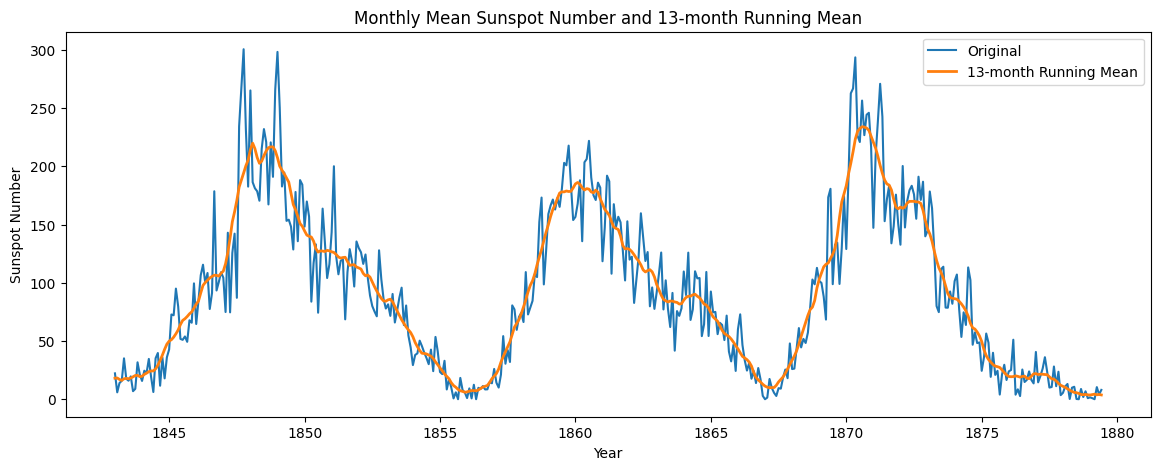

In [58]:
def running_mean_13month(data):
    n = len(data)
    smoothed = np.empty(n)
    for i in range(n):
        if i < 6:
            smoothed[i] = np.mean(data[:i+7])
        elif i > n - 7:
            smoothed[i] = np.mean(data[i-6:])
        else:
            smoothed[i] = (data[i-6]/24 + np.sum(data[i-5:i+6])/12 + data[i+6]/24)
    return smoothed

sunspot_smoothed_13mo = running_mean_13month(sunspot_numbers)

# Plot original and smoothed data
dates = years + (months - 1) / 12.0
plt.figure(figsize=(14,5))
plt.plot(dates, sunspot_numbers, label='Original')
plt.plot(dates, sunspot_smoothed_13mo, label='13-month Running Mean', linewidth=2)
plt.xlabel('Year')
plt.ylabel('Sunspot Number')
plt.title('Monthly Mean Sunspot Number and 13-month Running Mean')
plt.legend()
plt.show()

The graph shows that after applying 13 month running mean smoothing to the data alot of noise has been filtered and the regenerated curve (without noise) follows the same trend as of the actual curve (with noise).

### 3: Forward-backward exponential smoothing
Apply forward-backward exponential smoothing to the original monthly sunspot values.
Compare results with the 13-month running mean using deviation and variability indicators.
Try different smoothing constants \(\alpha\).

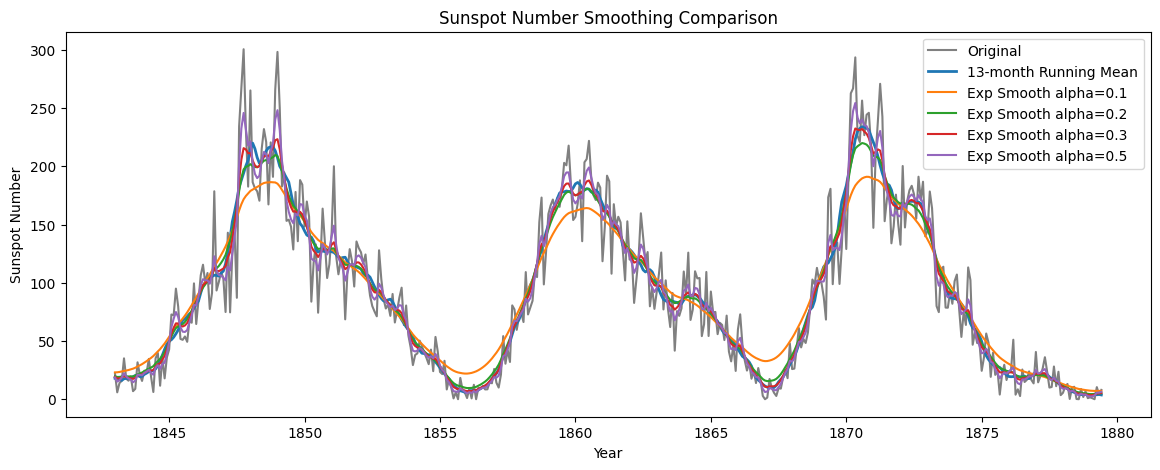

13-month running mean: I_d = 232675.214, I_v = 1576.221
Exp smoothing alpha=0.1: I_d = 325397.543, I_v = 40.172
Exp smoothing alpha=0.2: I_d = 216602.801, I_v = 541.471
Exp smoothing alpha=0.3: I_d = 171905.065, I_v = 2841.426
Exp smoothing alpha=0.5: I_d = 105147.820, I_v = 26283.219


In [59]:
def forward_exp_smooth(data, alpha):
    smoothed = np.zeros_like(data)
    smoothed[0] = data[0]
    for i in range(1, len(data)):
        smoothed[i] = alpha * data[i] + (1 - alpha) * smoothed[i-1]
    return smoothed

def backward_exp_smooth(data, alpha):
    smoothed = np.zeros_like(data)
    smoothed[-1] = data[-1]
    for i in range(len(data)-2, -1, -1):
        smoothed[i] = alpha * data[i] + (1 - alpha) * smoothed[i+1]
    return smoothed

def forward_backward_exp_smooth(data, alpha):
    forward = forward_exp_smooth(data, alpha)
    backward = backward_exp_smooth(forward, alpha)
    return backward

alphas = [0.1, 0.2, 0.3, 0.5]
plt.figure(figsize=(14,5))
plt.plot(dates, sunspot_numbers, label='Original', color='grey')
plt.plot(dates, sunspot_smoothed_13mo, label='13-month Running Mean', linewidth=2)
for alpha in alphas:
    smoothed_exp = forward_backward_exp_smooth(sunspot_numbers, alpha)
    plt.plot(dates, smoothed_exp, label=f'Exp Smooth alpha={alpha}')
plt.xlabel('Year')
plt.ylabel('Sunspot Number')
plt.title('Sunspot Number Smoothing Comparison')
plt.legend()
plt.show()

def compute_stats(original, smoothed):
    I_d = np.sum((original - smoothed) ** 2)
    N = len(original)
    I_v = np.sum((smoothed[2:N] - 2 * smoothed[1:N-1] + smoothed[0:N-2]) ** 2)
    return I_d, I_v 

dev_13mo, var_13mo = compute_stats(sunspot_numbers, sunspot_smoothed_13mo)
print(f"13-month running mean: I_d = {dev_13mo:.3f}, I_v = {var_13mo:.3f}")

for alpha in alphas:
    smoothed_exp = forward_backward_exp_smooth(sunspot_numbers, alpha)
    dev, var = compute_stats(sunspot_numbers, smoothed_exp)
    print(f"Exp smoothing alpha={alpha}: I_d = {dev:.3f}, I_v = {var:.3f}")

Forward backward smoothing was applied for alphas (0.1, 0.2, 0.3, 0.5) and was compared with each other as well as with the 13 month running mean curve. using the formulas the numerical values were calculated as well to compare better in the numerical terms.

Comparing the deviation indicators for exponential smoothing first when alpha was smaller; 0.1 MAD was higher meaning that the curve regenerated is more shifted than the actual one and the variability was the lowest showing that the the curve is smoother meaning the noise is filtered out more efficiently. But when alpha was greater say 0.5 reverse phenomenon was observed. Now if we compare MAD and variabilty indicators for 13 month running mean they also have higher values for both indicators showing that exponential smoothing is better than running mean method.

## Part II: 3D Surface Reconstruction Under Noise

To reconstruct the 3d Ssurface under noise again the data for group 5 was loaded.

In [60]:
surface_folder = 'data/'
noisy_surface = np.loadtxt(surface_folder + 'noisy_surface.txt')
true_surface = np.loadtxt(surface_folder + 'true_surface.txt')
print('Noisy surface shape:', noisy_surface.shape)
print('True surface shape:', true_surface.shape)

Noisy surface shape: (51, 51)
True surface shape: (51, 51)


### 2: Plot both surfaces with colorbars

In [61]:
from mpl_toolkits.mplot3d import Axes3D  # for 3D plotting

def plot_3d_surface(surface, title):
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(111, projection='3d')
    rows, cols = surface.shape
    X, Y = np.meshgrid(np.arange(cols), np.arange(rows))
    surf = ax.plot_surface(X, Y, surface, cmap='viridis', edgecolor='none')
    ax.set_title(title)
    ax.set_xlabel('X (Column Index)')
    ax.set_ylabel('Y (Row Index)')
    ax.set_zlabel('Surface Value')
    fig.colorbar(surf, shrink=0.5, aspect=10)
    plt.show()


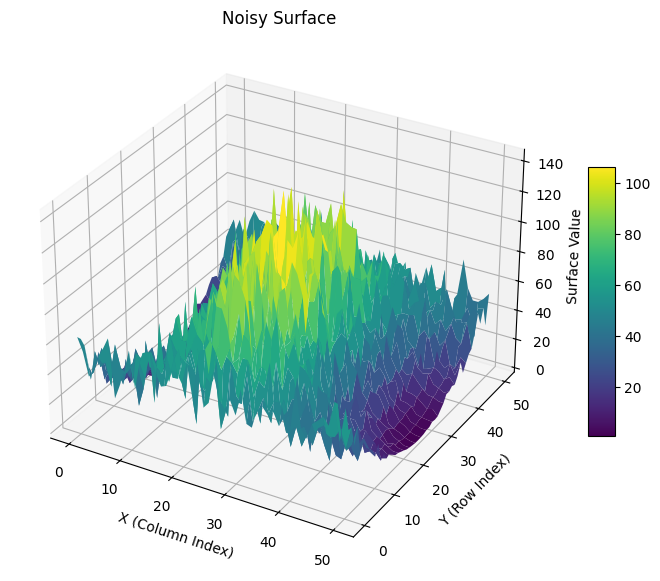

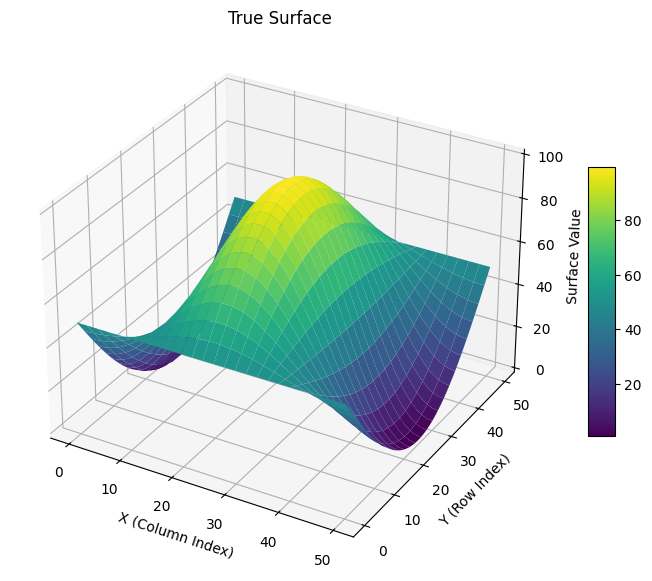

In [62]:

plot_3d_surface(noisy_surface, 'Noisy Surface')
plot_3d_surface(true_surface, 'True Surface')

The figure shows that both the noisy and true surfaces have been plotted and showing that the meaured data need to be filtered out in order to match the true data.

### 3: Calculate variance of deviation between noisy and true surfaces

To check the deviation between the true data and noisy measured data the variance was calculated as:

In [63]:
deviation_noisy = noisy_surface - true_surface
variance_noisy = np.var(deviation_noisy.reshape(-1))
print(f"Variance of deviation: {variance_noisy:.6f}")

Variance of deviation: 120.577620


### 4: Forward-backward exponential smoothing on noisy surface \(\alpha=0.335\)

Forward backward smoothing was applied in the folloowing manner by using α = 0.335:
1. Performed forward exponential smoothing on the rows (from left to right).
2. Then applied backward exponential smoothing to the results from Step 1 (from right to left).
3. After that conducted forward exponential smoothing on the results from Step 2 along the columns (from bottom to top).
4. At last backward exponential smoothing on the results from Step 3 along the columns (from top to bottom) was executed.

In [64]:
alpha = 0.335

def exp_smooth_1d(arr, alpha, forward=True):
    n = len(arr)
    smoothed = np.zeros_like(arr)
    if forward:
        smoothed[0] = arr[0]
        for i in range(1, n):
            smoothed[i] = alpha * arr[i] + (1 - alpha) * smoothed[i-1]
    else:
        smoothed[-1] = arr[-1]
        for i in range(n-2, -1, -1):
            smoothed[i] = alpha * arr[i] + (1 - alpha) * smoothed[i+1]
    return smoothed

def forward_backward_smooth_2d(surface, alpha):
    rows, cols = surface.shape
    temp1 = np.zeros_like(surface)
    for r in range(rows):
        temp1[r,:] = exp_smooth_1d(surface[r,:], alpha, forward=True)
    temp2 = np.zeros_like(surface)
    for r in range(rows):
        temp2[r,:] = exp_smooth_1d(temp1[r,:], alpha, forward=False)
    temp3 = np.zeros_like(surface)
    for c in range(cols):
        temp3[:,c] = exp_smooth_1d(temp2[:,c], alpha, forward=True)
    temp4 = np.zeros_like(surface)
    for c in range(cols):
        temp4[:,c] = exp_smooth_1d(temp3[:,c], alpha, forward=False)
    return temp4

smoothed_surface = forward_backward_smooth_2d(noisy_surface, alpha)

### Task 5: Visualize smoothed surface and true surface

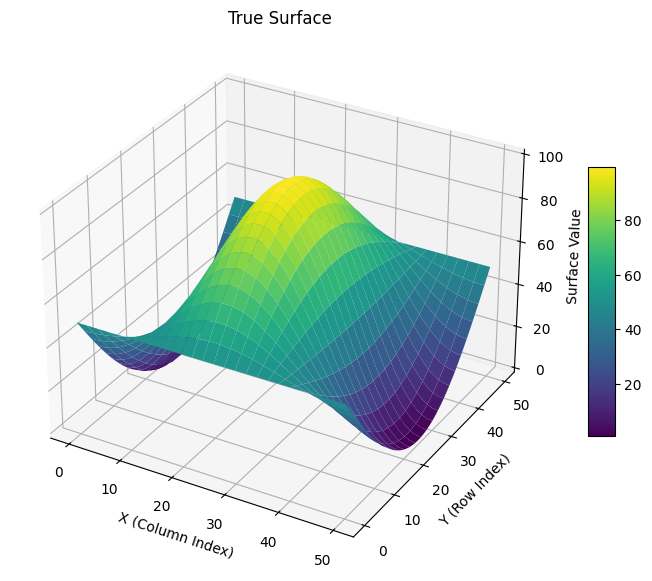

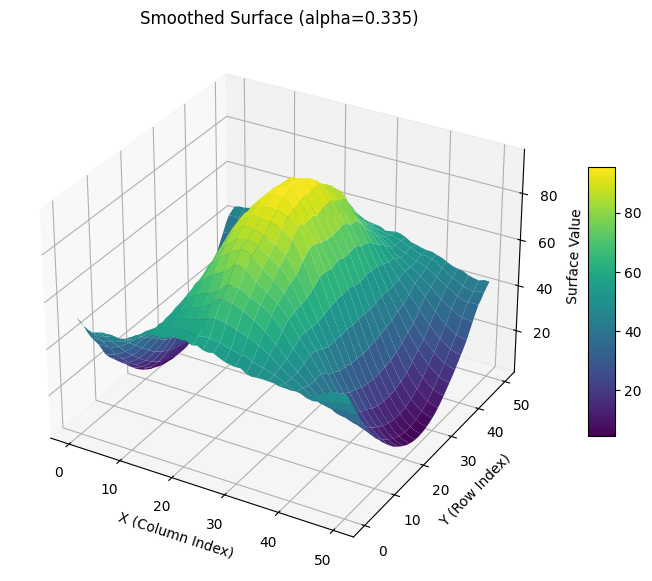

In [65]:
plot_3d_surface(true_surface, 'True Surface')
plot_3d_surface(smoothed_surface, 'Smoothed Surface (alpha=0.335)')

The figure shows that after applying forward backward smoothing with α 0.335 the measured surface is now similar to the true surface very much but still it has a little bit noise elements in it.

### Task 6: Calculate variance of deviation between smoothed and true surfaces

In [66]:
deviation_smoothed = smoothed_surface - true_surface
variance_smoothed = np.var(deviation_smoothed.reshape(-1))
print(f"Variance of deviation for smoothed: {variance_smoothed:.6f}")
print(f"Variance reduction by smoothing: {variance_noisy - variance_smoothed:.6f}")

Variance of deviation for smoothed: 7.072717
Variance reduction by smoothing: 113.504903


The deviation between the true surface and smoothed surface that were given to us was 120.577 and when we calculated it for the true surface and for the one that we plotted after using α = 0.335 the deviation comes out to be 7.0727 which shows that alot of noise has been removed. This shows that this method is effective to plot the true surface from the noisy surface but it still has some noise so we need to try other values of alpha as well.

### Task 7: Effect of varying smoothing constant \(\alpha\)
Try values smaller and greater than 0.335 and discuss the effect on smoothing.

alpha =    0.1: Variance of deviation = 238.352497
alpha =    0.2: Variance of deviation = 45.206446
alpha =    0.3: Variance of deviation = 10.571221
alpha =  0.335: Variance of deviation = 7.072717
alpha =    0.4: Variance of deviation = 4.366719
alpha =    0.5: Variance of deviation = 4.577336
alpha =    0.6: Variance of deviation = 7.802797
alpha =    0.7: Variance of deviation = 14.644298
alpha =    0.9: Variance of deviation = 56.715611


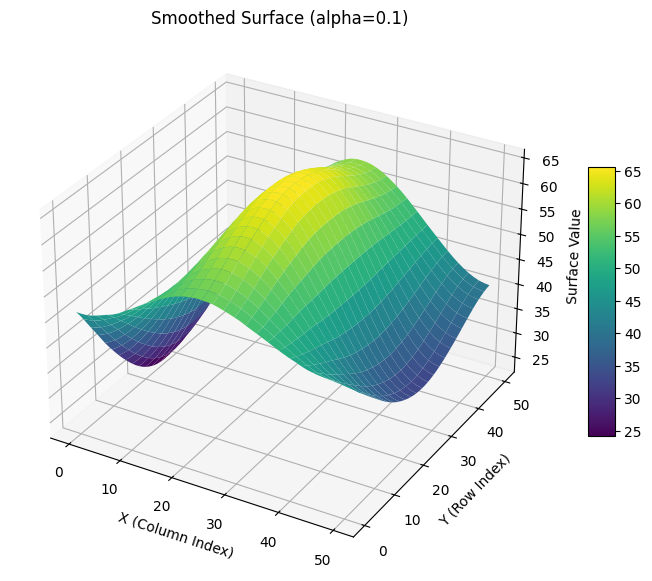

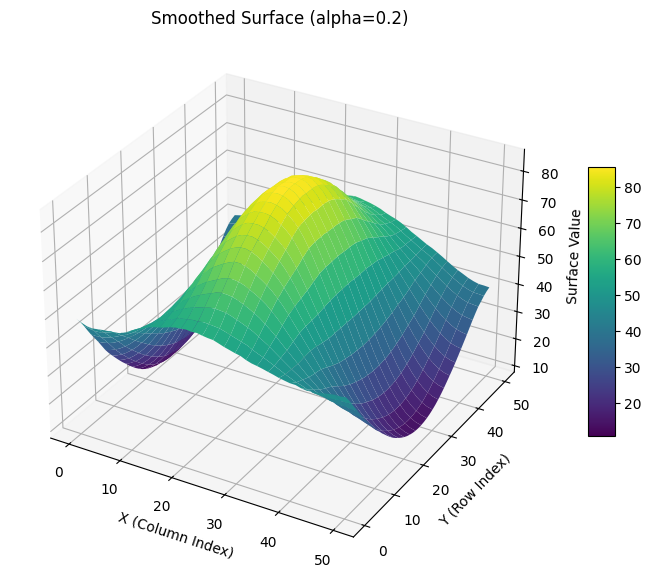

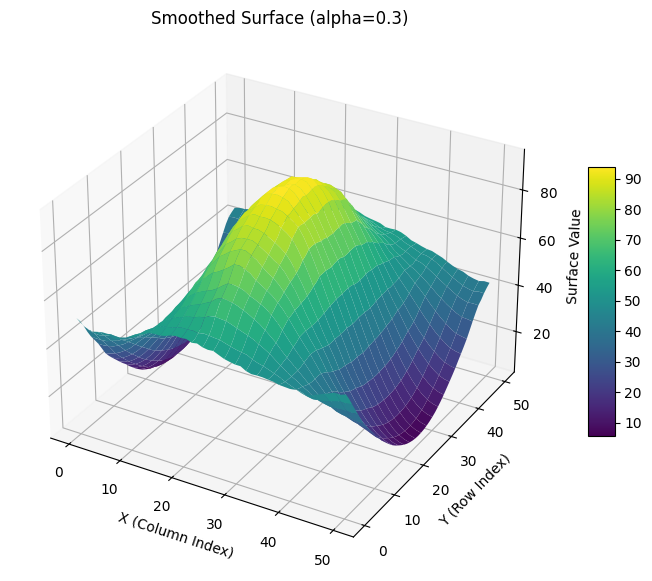

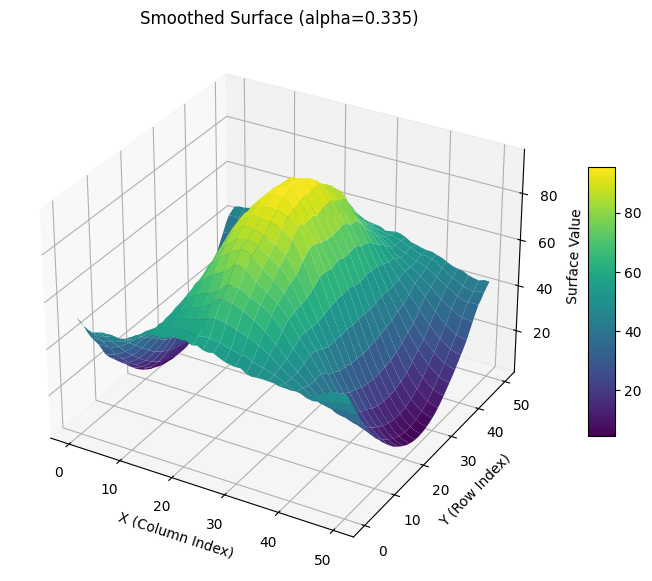

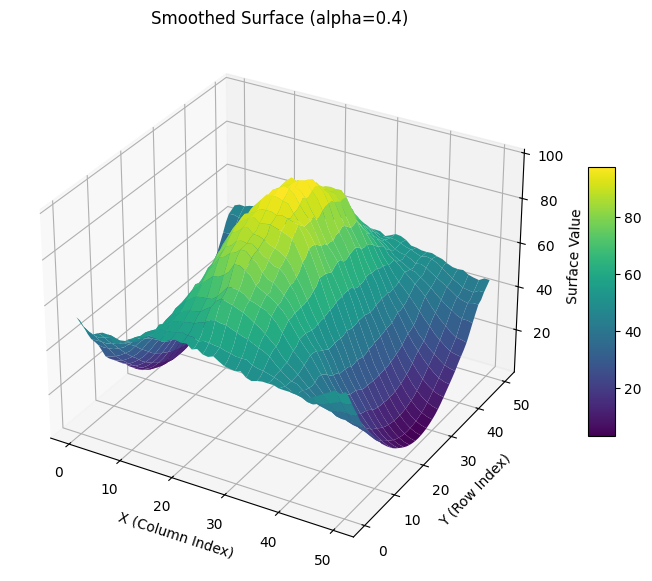

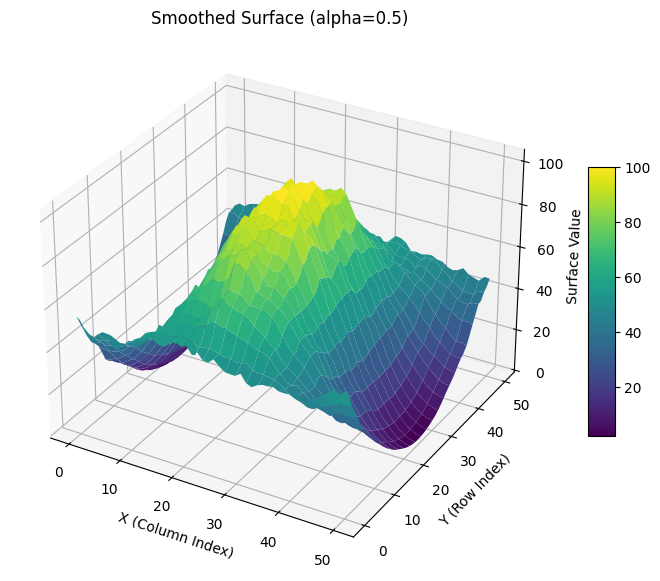

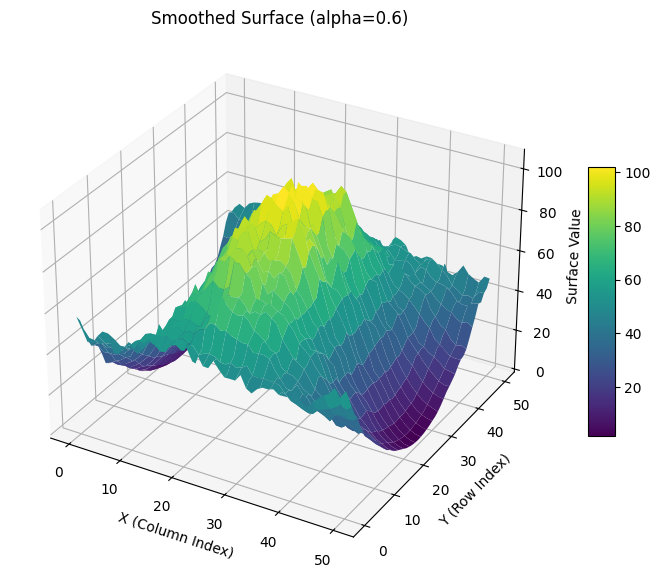

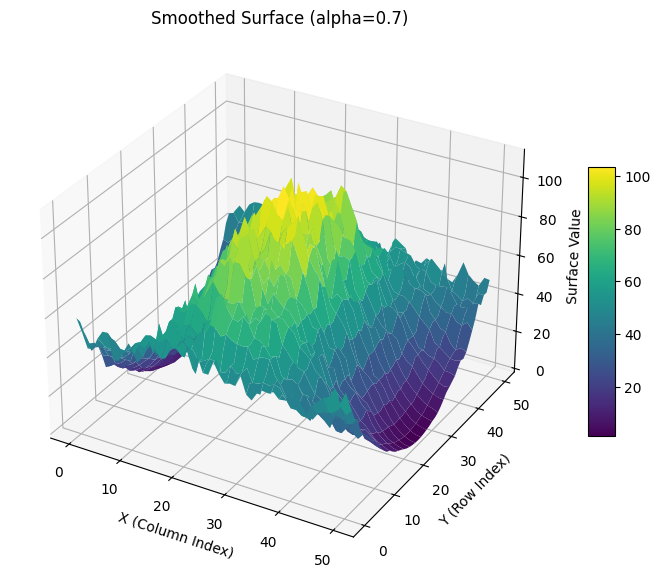

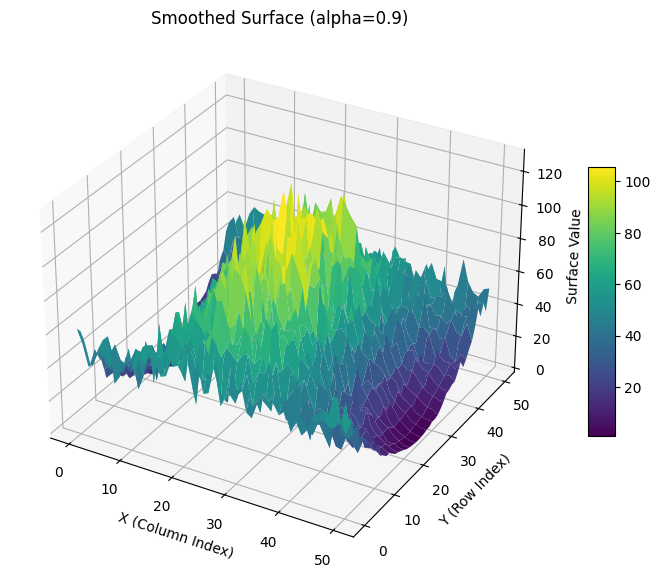

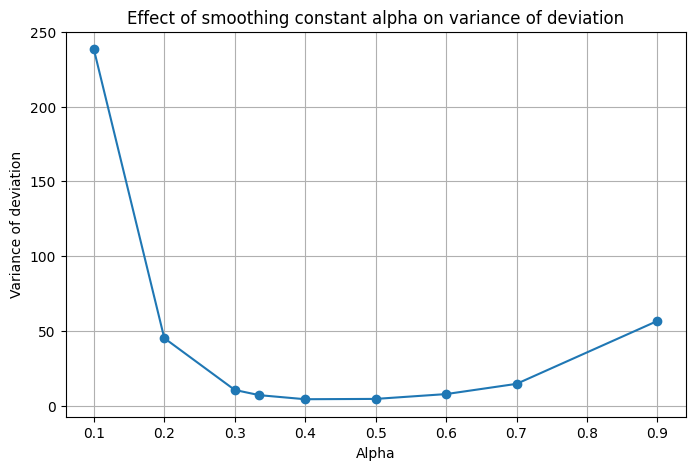

In [ ]:
alpha_values = [0.1, 0.2, 0.3, 0.335, 0.4, 0.5, 0.6, 0.7, 0.9]
variances = []
data_for_plot = []
for a in alpha_values:
    smooth = forward_backward_smooth_2d(noisy_surface, a)
    if a in [0.2, 0.3, 0.6]:
        data_for_plot.append([a, smooth])
    deviation = smooth - true_surface
    var = np.var(deviation.reshape(-1))
    variances.append(var)
    print(f"alpha = {a:6}: Variance of deviation = {var:.6f}")

for a, data in data_for_plot:
    plot_3d_surface(data, f'Smoothed Surface (alpha={a})')

plt.figure(figsize=(8,5))
plt.plot(alpha_values, variances, marker='o')
plt.title('Effect of smoothing constant alpha on variance of deviation')
plt.xlabel('Alpha')
plt.ylabel('Variance of deviation')
plt.grid(True)
plt.show()


Effect of alpha:
- Smaller alpha results in stronger smoothing, reducing noise but potentially blurring features.
- Larger alpha preserves data features but less noise reduction.
- Optimal alpha balances noise reduction with feature preservation.